In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 배터리 데이터

In [2]:
train_df = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\2025 수업\DA양성과정 ML\배터리 수명 예측\train.csv')
test_df = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\2025 수업\DA양성과정 ML\배터리 수명 예측\test.csv')

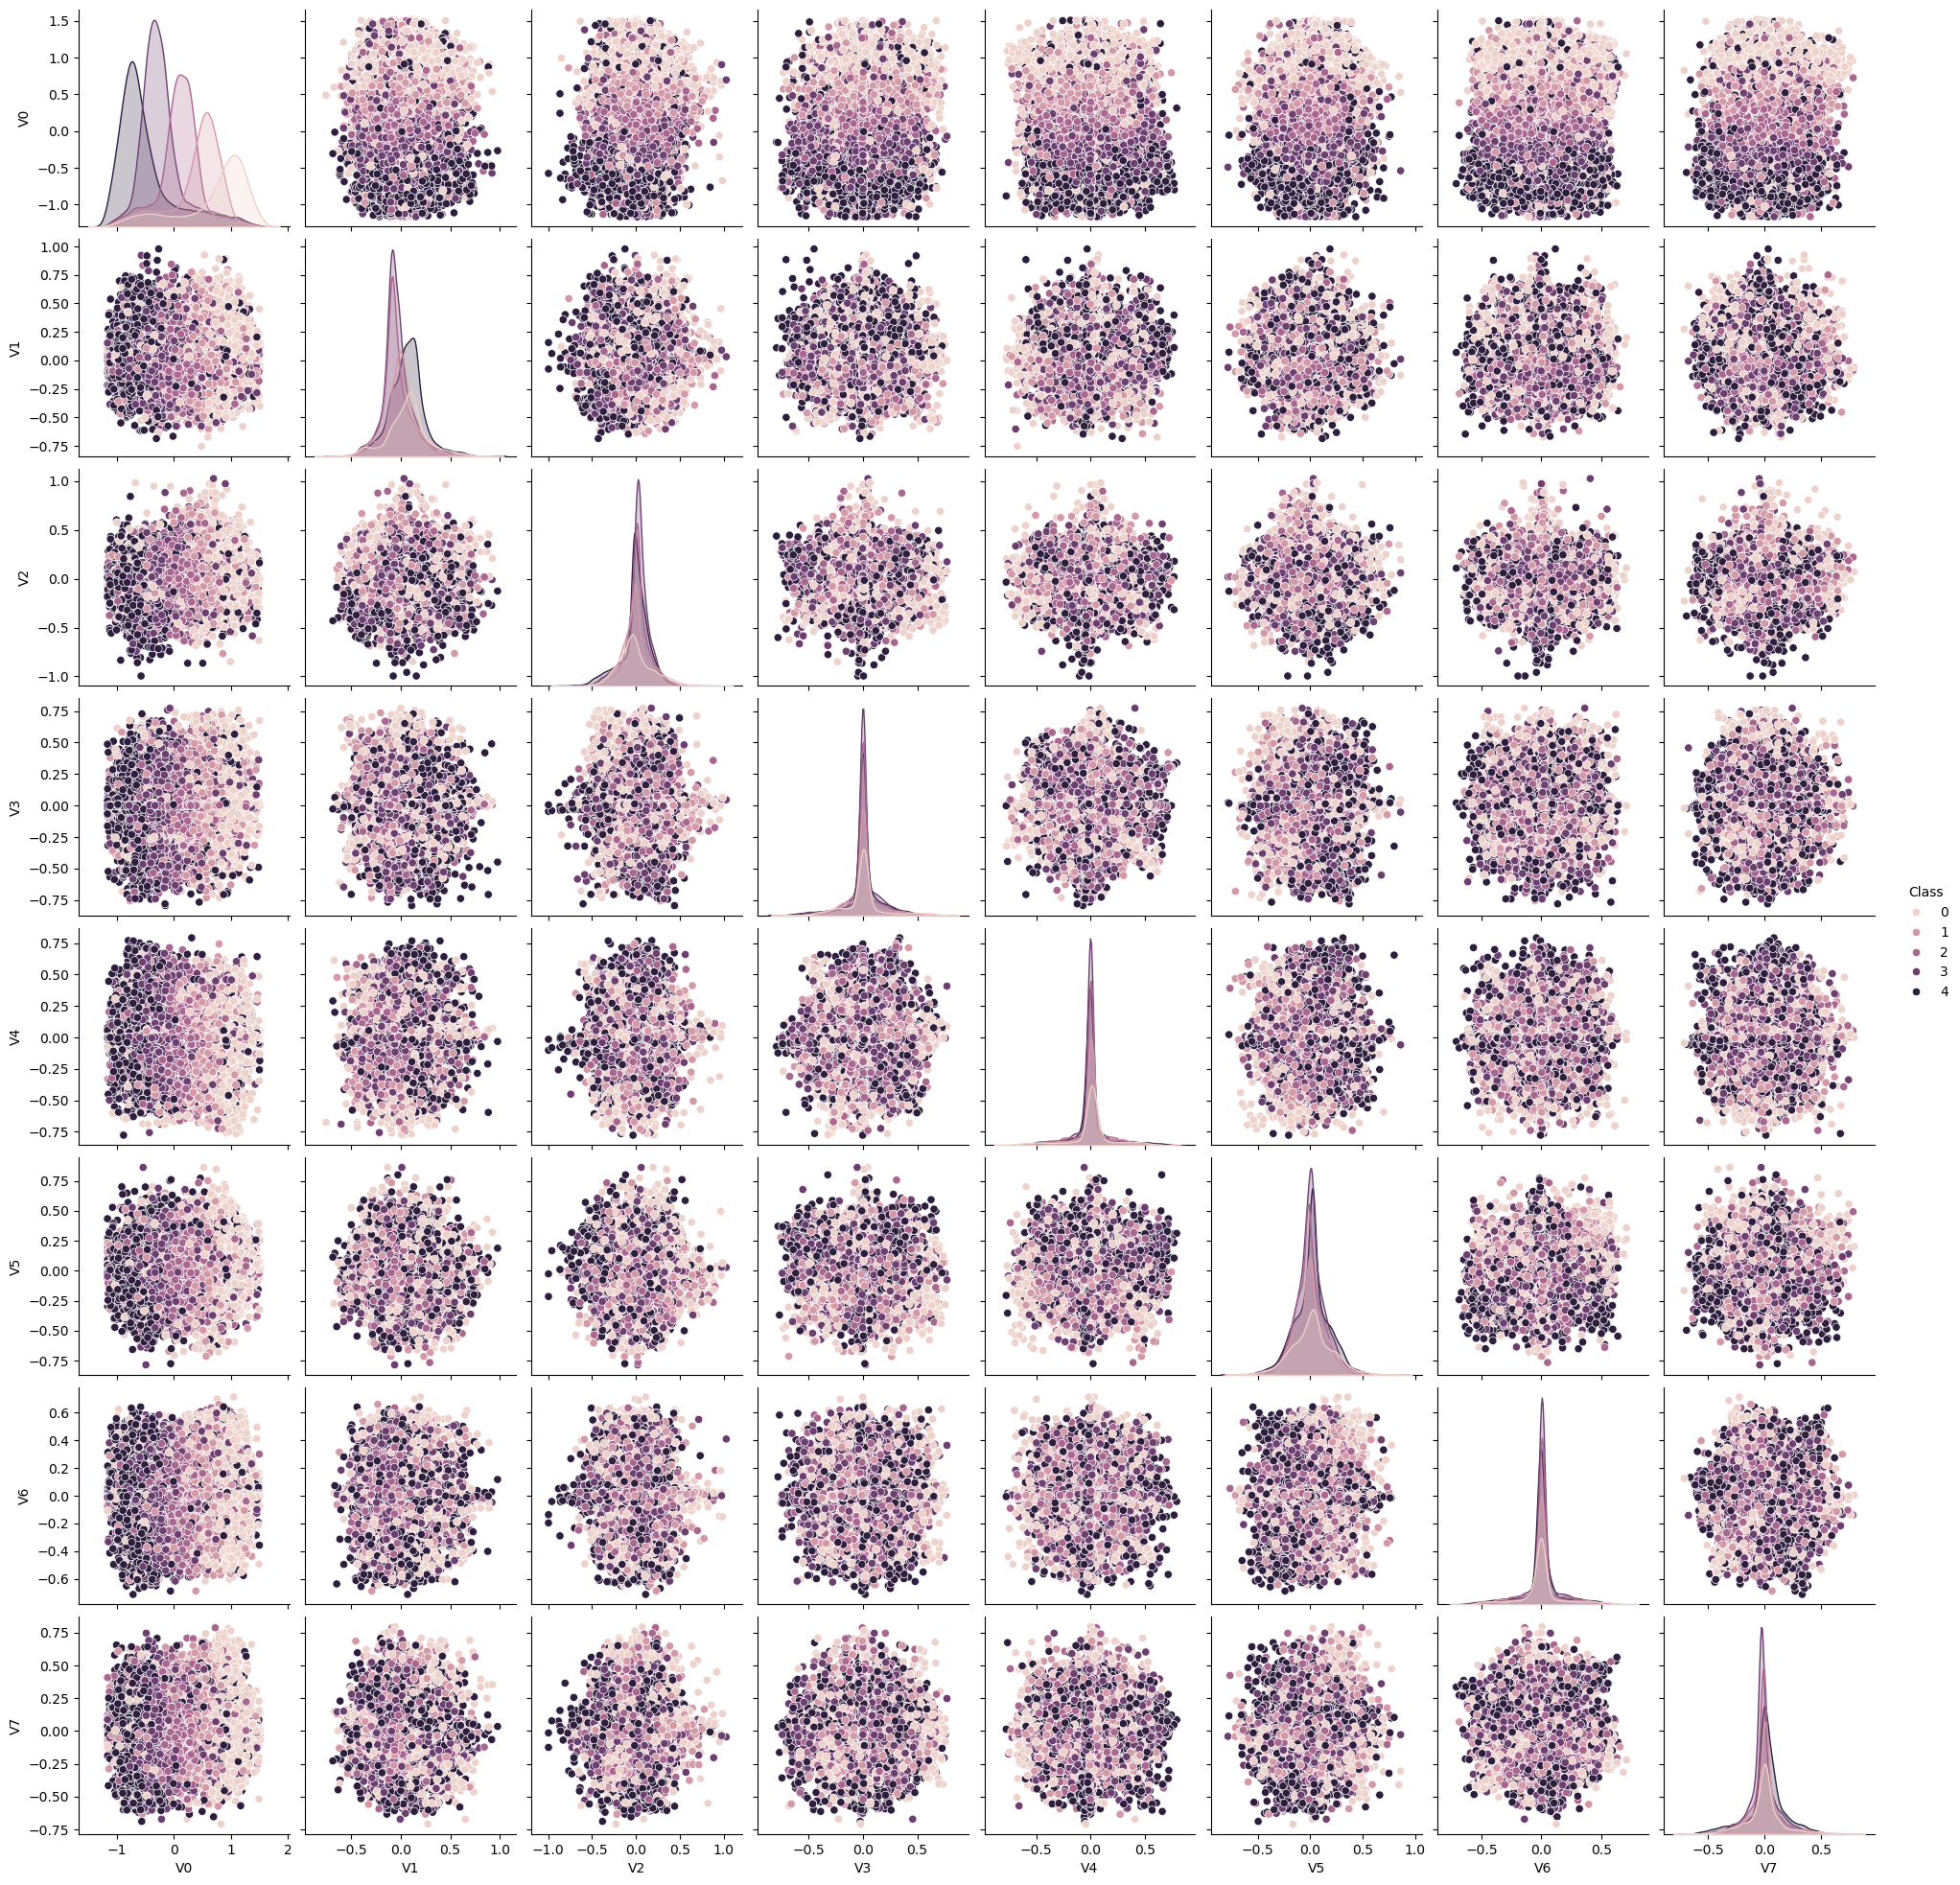

In [4]:
sns.pairplot(train_df, hue='Class')
plt.show()

## 결측 데이터 처리

In [8]:
train_df.isna().sum() / len(train_df) * 100

ID        0.000
V0       20.098
V1       19.974
V2       19.682
V3       20.328
V4       19.894
V5       19.876
V6       20.020
V7       20.052
Class     0.000
dtype: float64

In [9]:
test_df.isna().sum() / len(test_df) * 100

ID     0.000
V0    19.730
V1    20.014
V2    19.986
V3    20.100
V4    20.074
V5    19.712
V6    20.086
V7    20.260
dtype: float64

In [ ]:
for x in train_df.iloc[:, 1:-1].columns:
    plt.figure(figsize=(4, 2))
    sns.histplot(train_df, x=x, bins=30 )
    plt.show()

In [21]:
# 결측값을 평균으로 채우기
train_df2 = train_df.fillna( train_df.mean(numeric_only=True) )
test_df2 = test_df.fillna( train_df.mean(numeric_only=True) )

## Feature Engineering
- 스케일링

In [33]:
from sklearn.preprocessing import StandardScaler

train_df2.columns
features = ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

sc = StandardScaler()
sc.fit( train_df2[features] )
train_df2[features] = sc.transform( train_df2[features] )
test_df2[features] = sc.transform( test_df2[features] )

In [34]:
from sklearn.model_selection import train_test_split
X = train_df2[features]
y = train_df2['Class']
train_x, valid_x, train_y, valid_y = train_test_split(X, y,
                                                      test_size=0.3,
                                                      random_state=7,
                                                      stratify=y)

## KNN

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
# k를 찾아보자
params = {'n_neighbors':[5, 10, 15, 20, 25]}
grid_knn = GridSearchCV( KNeighborsClassifier(), params, cv=5  )
grid_knn.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 10, 15, 20, 25]})

In [38]:
grid_knn.score(valid_x, valid_y)

0.5722666666666667

In [39]:
grid_knn.predict( test_df2[features] )

array([1, 1, 3, ..., 3, 0, 2], dtype=int64)

## Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

params = {'max_depth':[3, 7, 11],
            'min_samples_leaf':[1, 7, 15]}
grid_tree = GridSearchCV( DecisionTreeClassifier(), params, cv=5)
grid_tree.fit(train_x, train_y)

In [ ]:
result = pd.DataFrame( grid_tree.cv_results_['params'])
result['score'] =  grid_tree.cv_results_['mean_test_score']
pd.pivot_table(result, columns='max_depth', index='min_samples_leaf')

In [45]:
grid_tree.score(valid_x, valid_y)

0.5816666666666667

In [47]:
grid_tree.best_estimator_.feature_importances_

array([0.66072762, 0.08340764, 0.06036247, 0.02093089, 0.06101492,
       0.03670597, 0.02192593, 0.05492455])

## Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth':[3, 7, 11],
            'min_samples_leaf':[1, 7, 15]}
grid_rf = GridSearchCV( RandomForestClassifier(), params, cv=5)
grid_rf.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 7, 11],
                         'min_samples_leaf': [1, 7, 15]})

In [50]:
grid_rf.score(valid_x, valid_y)

0.6178

## SVM

In [27]:
from sklearn.svm import SVC

# 회귀모델
- target 데이터의 종류가 연속된 숫자

In [51]:
from sklearn.datasets import load_diabetes

In [57]:
temp = load_diabetes()
diabetes_df = pd.DataFrame(temp['data'], columns=temp['feature_names'])
diabetes_df['target'] = temp['target']

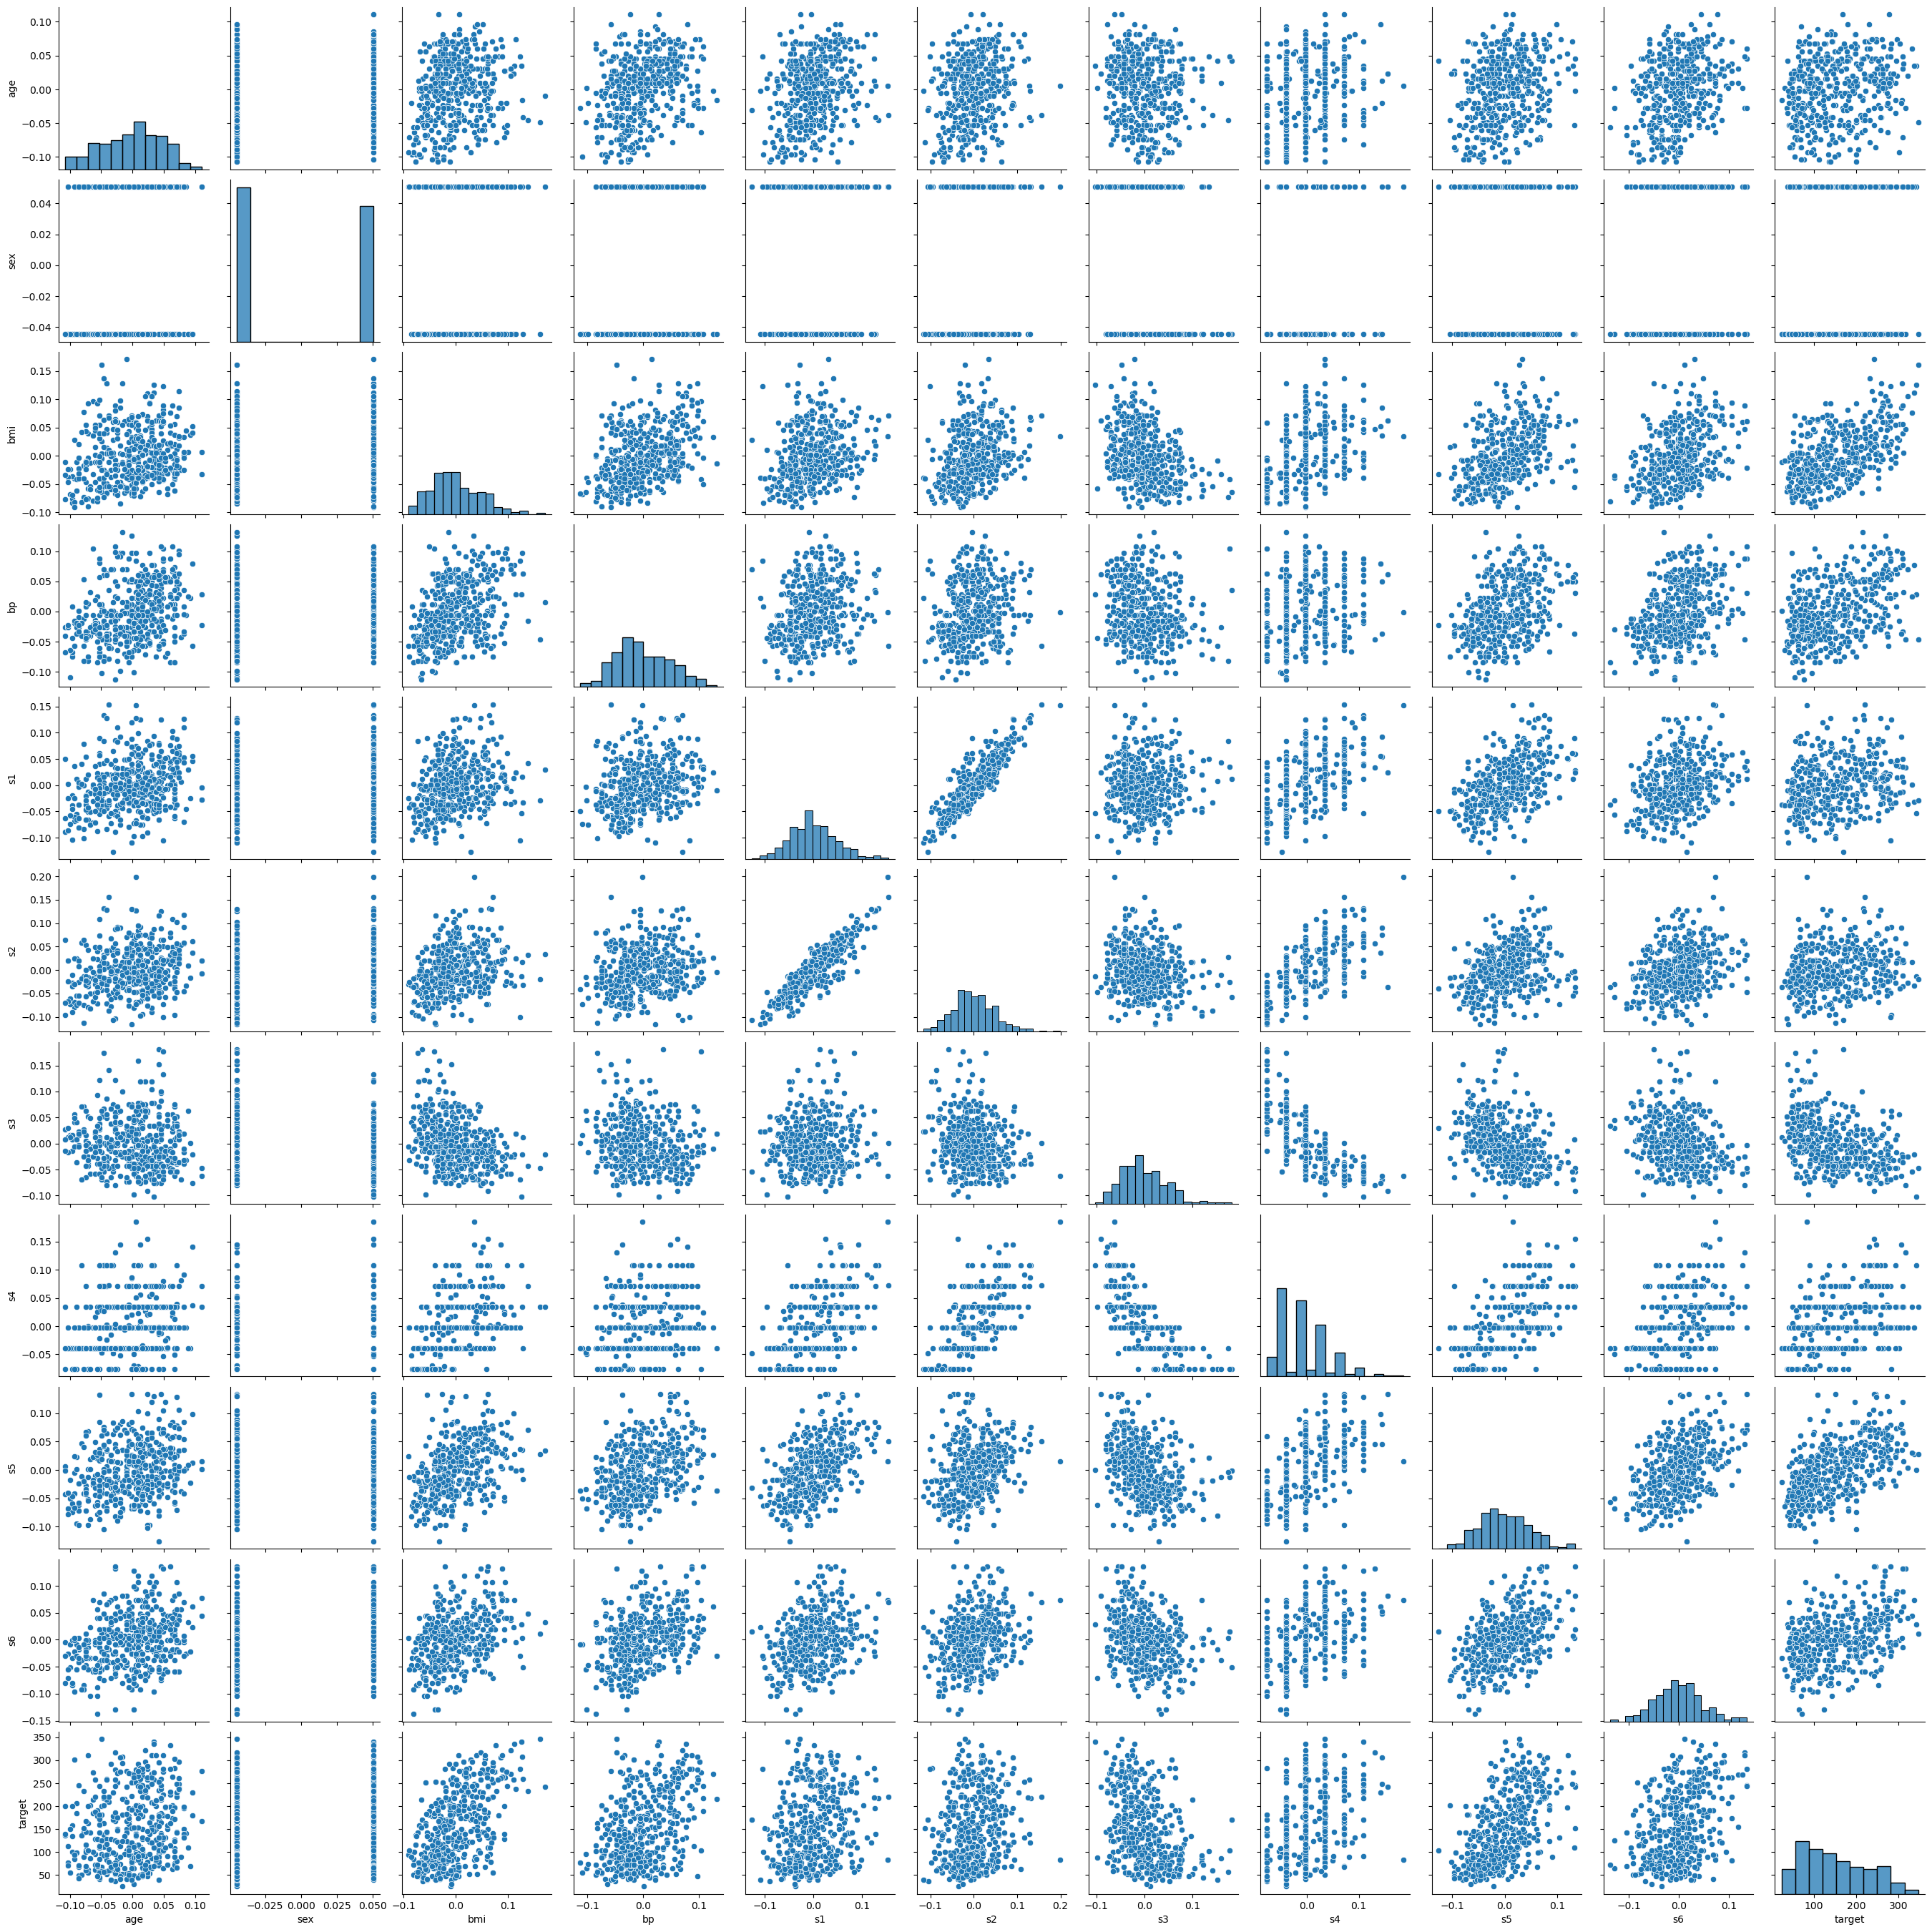

In [58]:
## EDA
sns.pairplot(diabetes_df)
plt.show()

In [61]:
# 통계 모델
    # 해석
    # 통계 모델 => 신뢰도
    # 선형관계, x가 정규분포, 잔차가 정규분포...

# 머신러닝 모델
    # 정확한 예측
    # 회귀계수, 예측값
    # 다중공성성 => feature들끼리 관계가 없어야 함

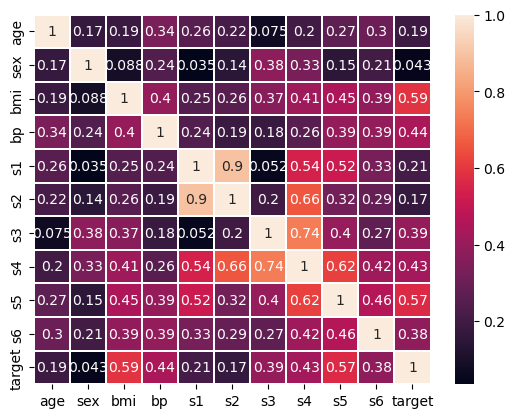

In [68]:
# corr => 연속된 숫자 데이터 사이에 선형 관계를 수치로 표현
# -1 ~ 1
sns.heatmap( np.abs( diabetes_df.corr() ), annot=True, lw=0.05 )
plt.show()

In [75]:
# VIF - 각 피쳐가 나머지 전체 데이터와 얼마나 연관이 있는지 계산
from statsmodels.stats.outliers_influence import variance_inflation_factor

for ix, val in enumerate(diabetes_df.iloc[:, :-1].columns):
    print(val, variance_inflation_factor(diabetes_df.iloc[:, :-1], ix) )

age 1.2173065138070072
sex 1.2780710154103625
bmi 1.5094373738445481
bp 1.4594277776838307
s1 59.202510134318615
s2 39.1933699727707
s3 15.402156007513453
s4 8.890986360329626
s5 10.075967132038336
s6 1.4846226073834825


In [79]:
diabetes_df2 = diabetes_df.drop( 's1', axis=1)
for ix, val in enumerate(diabetes_df2.iloc[:, :-1].columns):
    print(val, variance_inflation_factor(diabetes_df2.iloc[:, :-1], ix) )

age 1.2168924990717664
sex 1.2750486364396652
bmi 1.5023204346436043
bp 1.4574130684546214
s2 2.9265353553181814
s3 3.7368898006586306
s4 7.818670164713717
s5 2.1728652440836487
s6 1.48441026744797


In [80]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [92]:
# S1 았을때
X = diabetes_df.iloc[:, :-1]
y = diabetes_df['target']
train_x, valid_x, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=7)

In [93]:
# S1 았을때
# 회귀 모델의 score => R-square (0 ~ 1)
# 실제 평가값 => 오차

lr = LinearRegression()
lr.fit(train_x, train_y)
lr.score( valid_x, valid_y )

0.5116106826161886

In [95]:
pd.Series( lr.coef_, index=X.columns)

age    -48.422632
sex   -251.358912
bmi    501.008802
bp     361.769038
s1    -949.640077
s2     688.288844
s3      66.712613
s4      18.985783
s5     874.772781
s6      45.531329
dtype: float64

In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_squared_error(valid_y,  lr.predict(valid_x) ) ** 0.5

52.782069721072446

In [96]:
# S1 없을때
X = diabetes_df2.iloc[:, :-1]
y = diabetes_df2['target']
train_x, valid_x, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=7)

lr = LinearRegression()
lr.fit(train_x, train_y)
lr.score( valid_x, valid_y )

0.5114057887525763

In [91]:
mean_squared_error(valid_y,  lr.predict(valid_x) ) ** 0.5

52.79314038516466

In [97]:
pd.Series( lr.coef_, index=X.columns)

age    -50.732663
sex   -238.226042
bmi    507.253042
bp     351.969853
s2     -58.994335
s3    -335.199736
s4     -93.225372
s5     538.452399
s6      38.336510
dtype: float64

In [98]:
X = diabetes_df.iloc[:, :-1]
y = diabetes_df['target']
train_x, valid_x, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=7)

ridge = Ridge(alpha=0)
ridge.fit(train_x, train_y)
print( ridge.score(valid_x, valid_y) )
pd.Series( ridge.coef_, index=X.columns)

0.5116106826161875


age    -48.422632
sex   -251.358912
bmi    501.008802
bp     361.769038
s1    -949.640077
s2     688.288844
s3      66.712613
s4      18.985783
s5     874.772781
s6      45.531329
dtype: float64

In [99]:
ridge = Ridge(alpha=0.5)
ridge.fit(train_x, train_y)
print( ridge.score(valid_x, valid_y) )
pd.Series( ridge.coef_, index=X.columns)

0.48986859307534336


age     13.552587
sex   -113.642982
bmi    333.950785
bp     238.388668
s1      -0.876851
s2     -41.912821
s3    -168.058749
s4     101.210529
s5     310.383064
s6     102.313436
dtype: float64

In [103]:
ridge = Ridge(alpha=1)
ridge.fit(train_x, train_y)
print( ridge.score(valid_x, valid_y) )
pd.Series( ridge.coef_, index=X.columns)

0.43932996680420866


age     27.133336
sex    -65.456090
bmi    254.445064
bp     185.939896
s1      17.370839
s2     -14.402230
s3    -136.557403
s4      99.672489
s5     236.027072
s6     101.175645
dtype: float64

In [105]:
lasso = Lasso(alpha=0.3)
lasso.fit(train_x, train_y)
print( lasso.score(valid_x, valid_y) )
pd.Series( lasso.coef_, index=X.columns)

0.4921812724964211


age     -0.000000
sex    -12.787871
bmi    470.444105
bp     222.856171
s1      -0.000000
s2      -0.000000
s3    -110.173073
s4       0.000000
s5     453.996434
s6       0.000000
dtype: float64

In [110]:
# KNN
from sklearn.neighbors import KNeighborsRegressor

params = {'n_neighbors':[5, 10, 15, 20, 25, 30 ]}
grid_knn_r = GridSearchCV( KNeighborsRegressor(), params, cv=5,
                         scoring='neg_root_mean_squared_error' )
grid_knn_r.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 10, 15, 20, 25, 30]},
             scoring='neg_root_mean_squared_error')

In [ ]:
plt.figure(figsize=(5, 2))
plt.plot( grid_knn_r.cv_results_['mean_test_score'])
plt.show()

In [113]:
grid_knn_r.best_params_

{'n_neighbors': 25}

# 자전거 수요 예측

In [117]:
train_df = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\2025 수업\DA양성과정 ML\train.csv')
test_df = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\2025 수업\DA양성과정 ML\test.csv')

In [119]:
# EDA
# 카테고리 데이터    : season, holiday, workingday, weather
# 연속된 숫자 데이터 : temp, atemp, humidity, windspeed, target
# 데이터가 아닌 것   : datetime

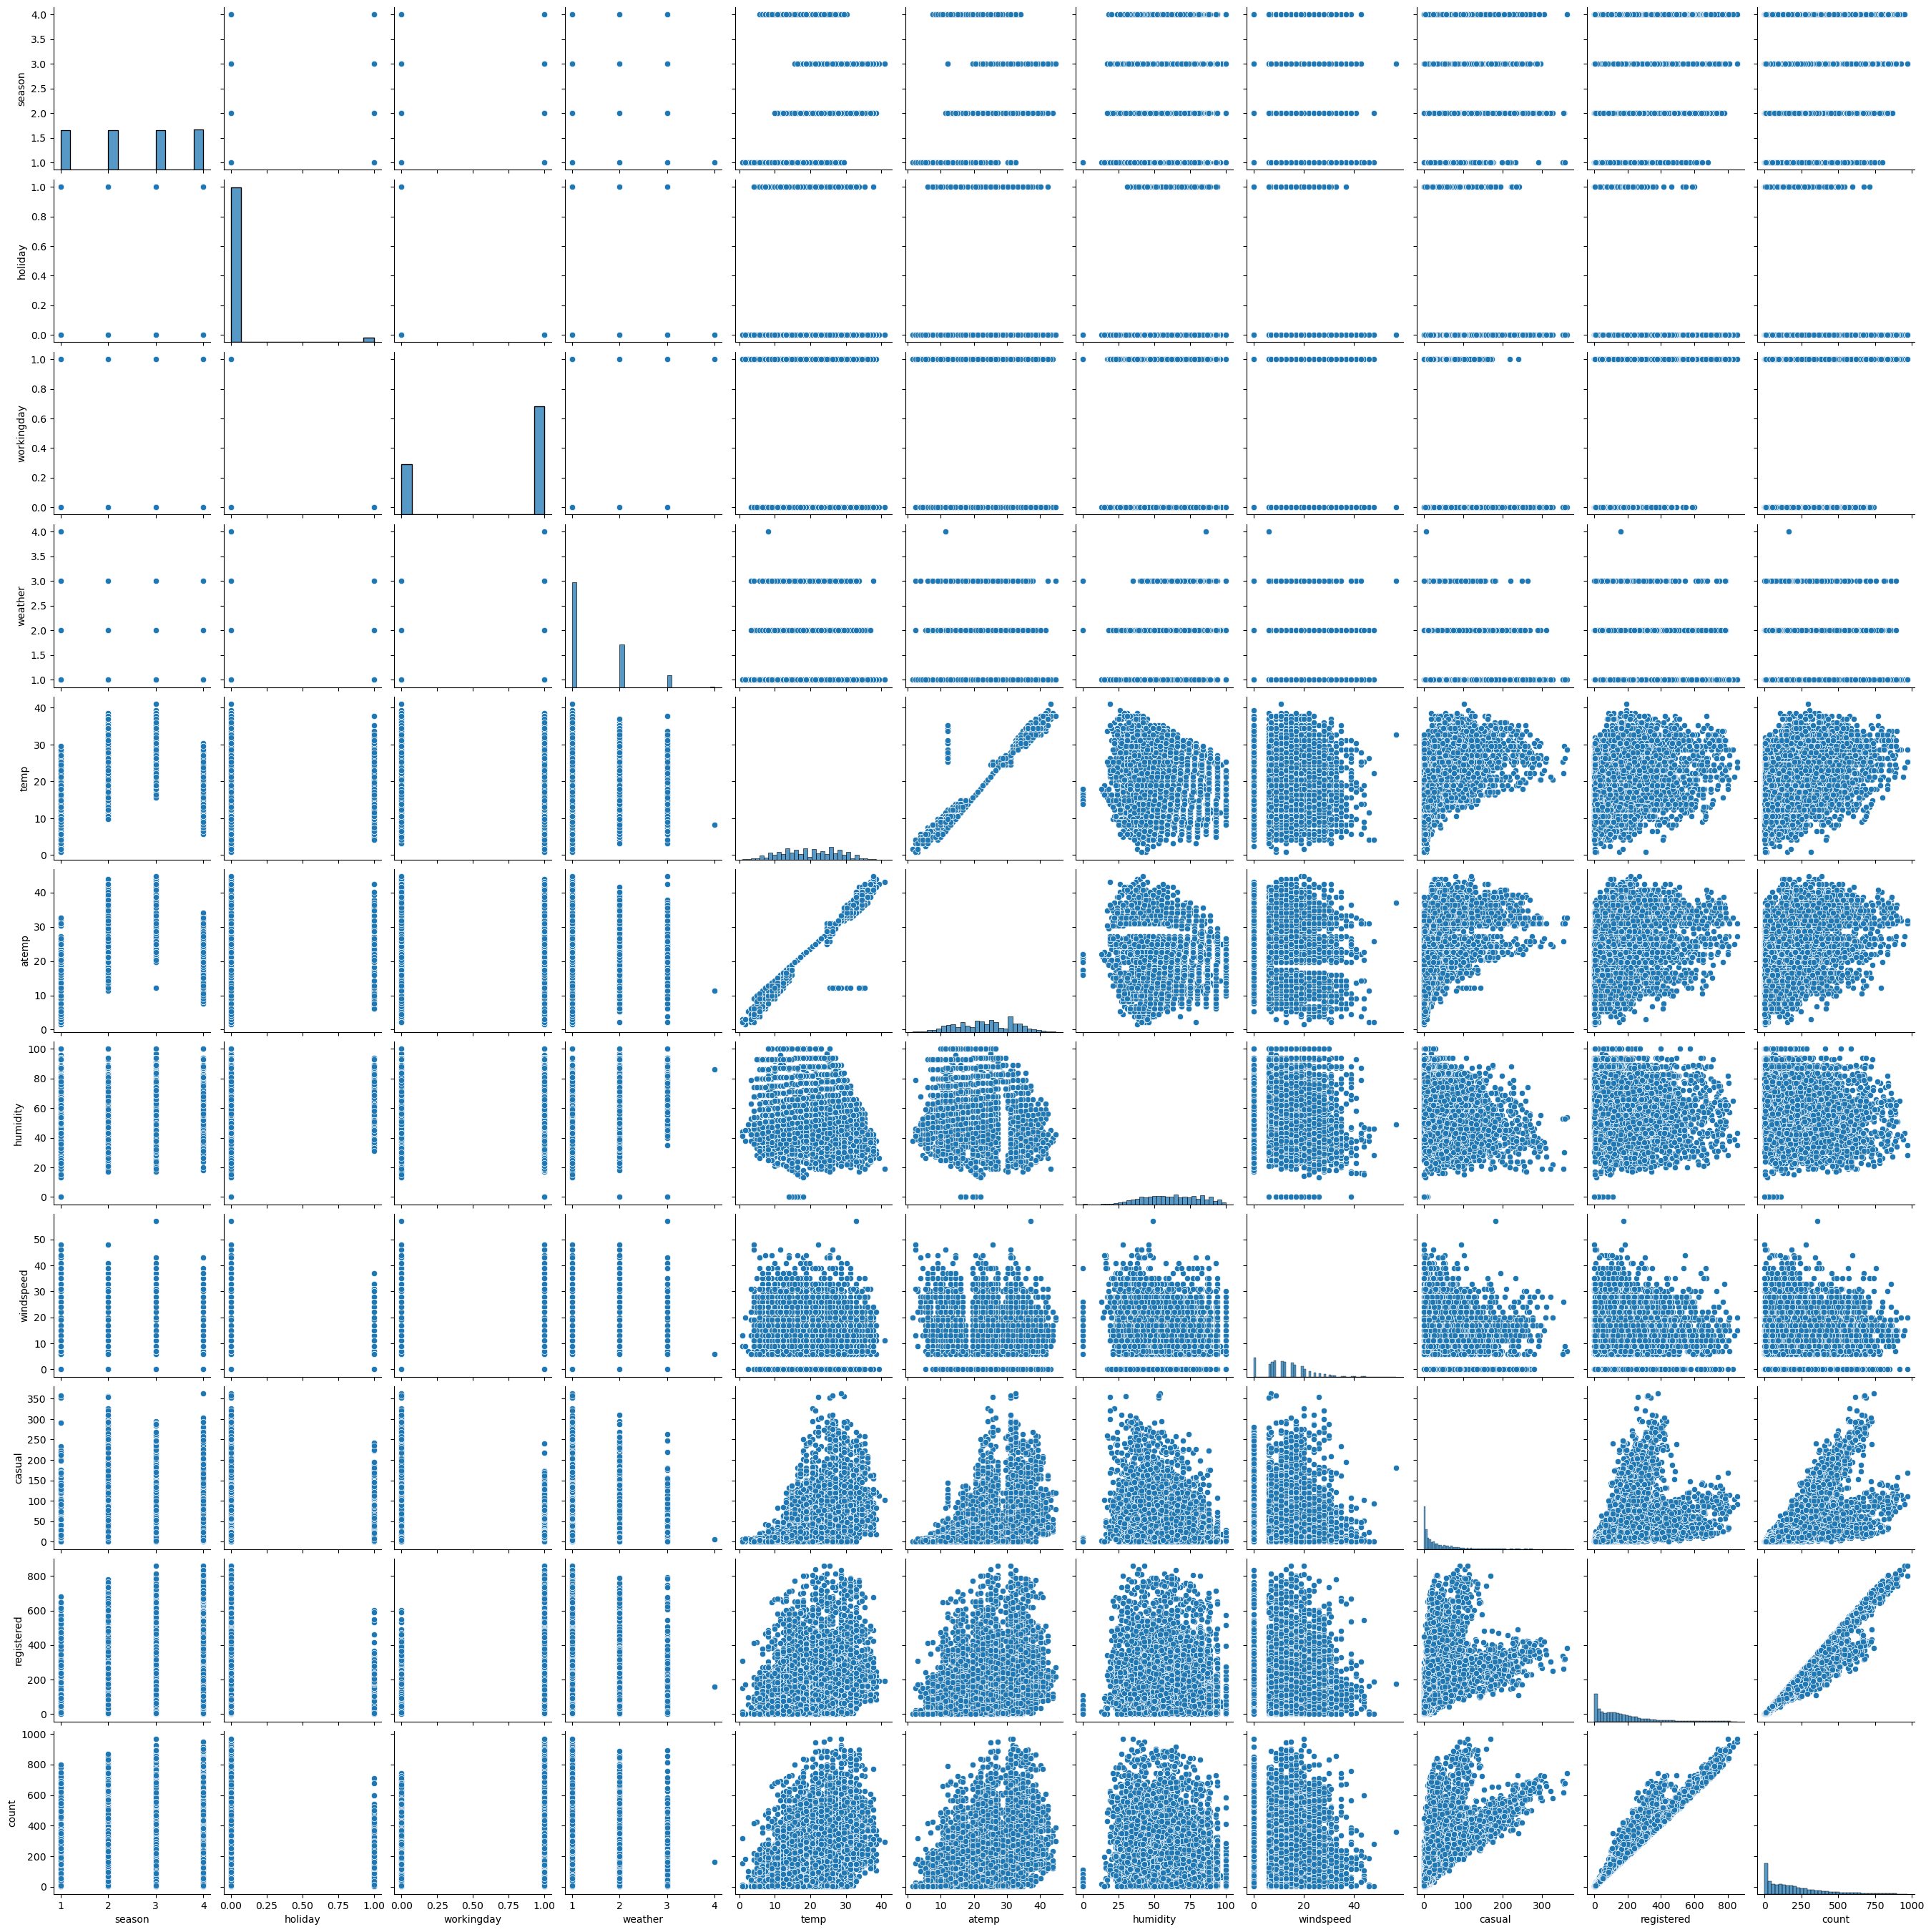

In [120]:
sns.pairplot( train_df )
plt.show()

In [123]:
# 결측 데이터 처리
train_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## Feature Engineering

In [ ]:
# 데이터가 아닌 것에서 데이터 추출 : datetime
# 연속된 숫자 데이터 => scailing : temp, atemp, humidity, windspeed, target
# 카테고리 데이터 => encoding   : season, holiday, workingday, weather

In [138]:
train_df['datetime'] = pd.to_datetime( train_df['datetime'] )
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour

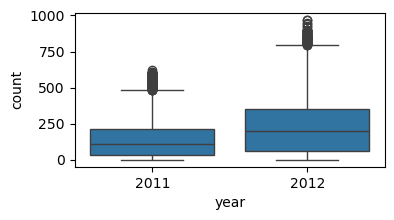

In [139]:
plt.figure(figsize=(4, 2))
sns.boxplot(train_df, x='year', y='count')
plt.show()

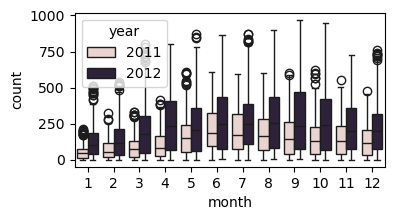

In [141]:
plt.figure(figsize=(4, 2))
sns.boxplot(train_df, x='month', y='count', hue='year')
plt.show()

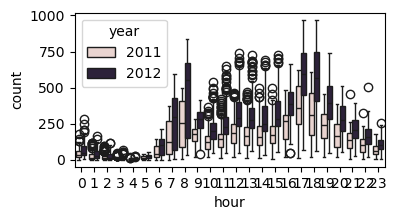

In [144]:
plt.figure(figsize=(4, 2))
sns.boxplot(train_df, x='hour', y='count', hue='year')
plt.show()

In [152]:
# 연속된 숫자 데이터로 사용 => 순환성을 표현하기 위해 삼각함수로 변환
train_df['sin_hour'] = np.sin( (train_df['hour'] / 24) * 2 * np.pi )
train_df['cos_hour'] = np.cos( (train_df['hour'] / 24) * 2 * np.pi )

In [155]:
test_df['datetime'] = pd.to_datetime( test_df['datetime'] )
test_df['year'] = test_df['datetime'].dt.year
test_df['hour'] = test_df['datetime'].dt.hour

# 연속된 숫자 데이터로 사용 => 순환성을 표현하기 위해 삼각함수로 변환
test_df['sin_hour'] = np.sin( (test_df['hour'] / 24) * 2 * np.pi )
test_df['cos_hour'] = np.cos( (test_df['hour'] / 24) * 2 * np.pi )

In [ ]:
# 숫자 데이터 스케일링
# 'temp', 'humidity', 'windspeed','sin_hour', 'cos_hour'

In [161]:
from sklearn.preprocessing import StandardScaler

scailing_features = ['temp', 'humidity', 'windspeed','sin_hour', 'cos_hour']
sc = StandardScaler()
sc.fit(train_df[scailing_features])
X = pd.DataFrame( sc.transform( train_df[scailing_features] ), columns=scailing_features)
test_X = pd.DataFrame( sc.transform( test_df[scailing_features] ), columns=scailing_features)

In [ ]:
# 카테고리 데이터 인코딩
# 'season', 'holiday', 'workingday', 'weather','year'

In [167]:
from sklearn.preprocessing import OneHotEncoder
encoding_features = ['season', 'holiday', 'workingday', 'weather','year']
onehot = OneHotEncoder( drop='first', sparse_output=False )
onehot.fit( train_df[encoding_features] )
X[ onehot.get_feature_names_out() ] = onehot.transform( train_df[encoding_features] )
test_X[ onehot.get_feature_names_out() ] = onehot.transform( test_df[encoding_features] )

In [174]:
y = train_df['count']
train_x, valid_x, train_y, valid_y = train_test_split(X,
                                                      y,
                                                      test_size=0.3,
                                                      random_state=1)

## 선형회귀 모델 사용

In [181]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

In [176]:
lr = LinearRegression()
lr.fit(train_x, train_y)
lr.score(valid_x, valid_y)

0.47169637221518634

In [192]:
temp = lr.predict(train_x)
temp[ temp < 0 ] = 0

array([347.79982901,  66.52991879, 327.2876326 , ...,   7.48022172,
       140.19453832,   0.        ])

In [194]:
mean_squared_log_error( train_y, temp ) ** 0.5

1.1096364804935421

In [195]:
temp = lr.predict(valid_x)
temp[ temp < 0 ] = 0
mean_squared_log_error(valid_y, temp) ** 0.5

1.1144246626616061

In [ ]:
result_lr = test_df[['datetime']].copy()
temp = lr.predict(test_X)
temp[temp <0 ] = 0
result_lr['count'] = temp
result_lr.to_csv(r'경로/파일명.csv', index=False)

## KNN 

## RandomForest